# Product Matching Project -- STSB dataset - S-BERT model


### Key steps:
    1. Load benchmark STSB datasets
    2. Text Preprocessing
    3. Calculate Lexical overlap: Jaccard Similarity 
    4. Load LLM model: SBERT
    5. Semantic Embedding
    6. Cosine Similarity
    7. Combine Lexical and Semantic similairity 
    8. Product Matching based on Combined similarity

In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity
import numpy as np
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load Dataset

In [2]:
df = pd.read_csv('../../datasets/stsb/stsb_train',)
catalog_a, catalog_b, score = list(df['sentence1']), list(df['sentence2']), list(df['score'])

number_of_rows = 10
catalog_a = catalog_a[:number_of_rows]
catalog_b = catalog_b[:number_of_rows]
ref_score = score[:number_of_rows]

## 2. Text Preprocessing


Before encoding or comparing texts, we normalize them to reduce noise.

Common techniques:

    - Lowercasing
    - Removing punctuation
    - Removing extra whitespace
    - Tokenization (splitting into words)

Why?
It improves consistency and reduces variability.
E.g., "256GB" vs "256 GB" — preprocessing helps align them better.

In [3]:
import re
import nltk
from nltk.corpus import stopwords

# Make sure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ----------- Preprocessing ----------
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove excess spaces
    tokens = text.split()
    # tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/egharibnezhad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:

# ----------- Preprocess titles -----------
catalog_a_clean = [preprocess(title) for title in catalog_a]
catalog_b_clean = [preprocess(title) for title in catalog_b]

In [5]:
import random
sampled_pairs = random.sample(list(zip(catalog_a, catalog_a_clean)), k=3)
sampled_pairs

[('A person is throwing a cat on to the ceiling.',
  'a person is throwing a cat on to the ceiling'),
 ('A man is spreading shreded cheese on a pizza.',
  'a man is spreading shreded cheese on a pizza'),
 ('A plane is taking off.', 'a plane is taking off')]

## 3. Jaccard Similarity Function



The `jaccard_similarity()` function calculates the **Jaccard Index**, a classic metric for measuring the similarity between two sets of tokens (words). Here's a breakdown of how it works:

**Formula**:

   $$
   \text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
   $$

   * $A$ and $B$ are sets of tokens from each input string.
   * $|A \cap B|$ is the size of the intersection.
   * $|A \cup B|$ is the size of the union.

The score ranges from **0 to 1**:

* **0** → no common words
* **1** → identical token sets

---

### Why It's Useful

While **semantic similarity models** (like SBERT) capture meaning, Jaccard focuses purely on **surface-level lexical overlap** — the words themselves.

This is especially useful when:

* Product names contain shared keywords (e.g., model numbers, storage capacity, brand).
* You want a fast, interpretable similarity measure.
* Synonym handling isn't necessary.

For example:

* \`"iPhone 13 Pro Max 128GB


In [6]:
# ----------- Jaccard Similarity ----------
def jaccard_similarity(str1, str2):
    a, b = set(str1.split()), set(str2.split())
    intersection = a.intersection(b)
    union = a.union(b)
    return len(intersection) / len(union) if union else 0


# ----------- Jaccard Similarity (Token-level) -----------
jaccard_sim = np.zeros((len(catalog_a),len(catalog_b)))
for i, title_a in enumerate(catalog_a_clean):
    for j, title_b in enumerate(catalog_b_clean):
        jaccard_sim[i, j] = jaccard_similarity(title_a, title_b)



In [7]:
pd.DataFrame(jaccard_sim)

,0,1,2,3,4,5,6,7,8,9
0,0.571429,0.250000,0.153846,0.000000,0.200000,0.000000,0.285714,0.111111,0.166667,0.090909
1,0.090909,0.833333,0.230769,0.100000,0.444444,0.000000,0.428571,0.375000,0.250000,0.083333
2,0.076923,0.300000,0.636364,0.000000,0.250000,0.000000,0.333333,0.181818,0.133333,0.153846
3,0.000000,0.111111,0.000000,0.666667,0.090909,0.285714,0.000000,0.111111,0.076923,0.000000
4,0.090909,0.571429,0.230769,0.100000,0.857143,0.000000,0.428571,0.571429,0.250000,0.181818
5,0.000000,0.000000,0.000000,0.285714,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000
6,0.111111,0.500000,0.272727,0.000000,0.375000,0.000000,0.600000,0.285714,0.181818,0.100000
7,0.100000,0.428571,0.153846,0.111111,0.500000,0.000000,0.285714,0.666667,0.166667,0.090909
8,0.076923,0.444444,0.285714,0.083333,0.363636,0.000000,0.333333,0.444444,0.545455,0.153846
9,0.071429,0.166667,0.187500,0.000000,0.230769,0.000000,0.181818,0.166667,0.125000,0.600000


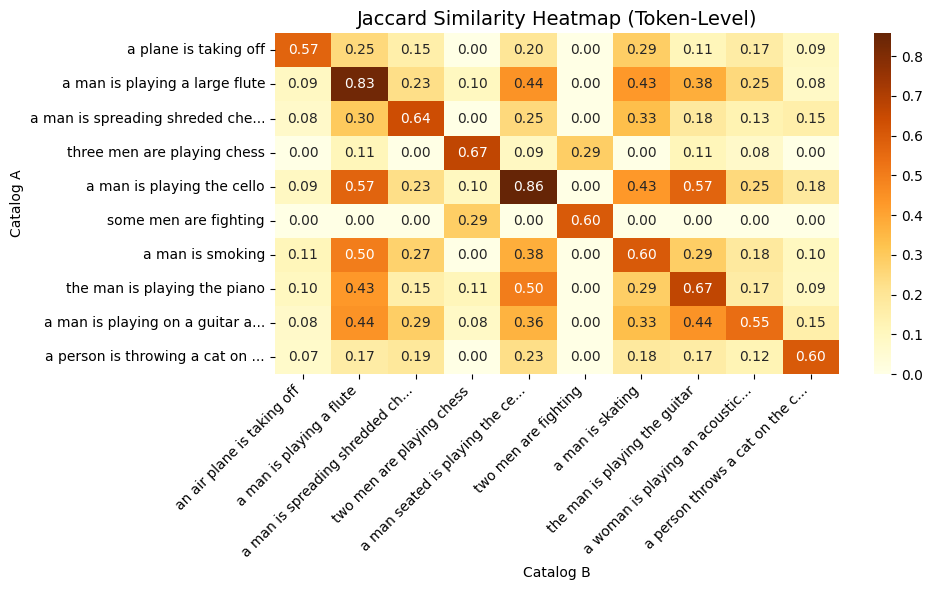

In [8]:
# Optional: truncate long strings for cleaner axis labels
def truncate(text, max_len=30):
    return text if len(text) <= max_len else text[:max_len] + '...'

# Create shorter labels for readability
labels_a = [truncate(s) for s in catalog_a_clean]
labels_b = [truncate(s) for s in catalog_b_clean]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(jaccard_sim, annot=True, fmt=".2f", cmap="YlOrBr",
            xticklabels=labels_b, yticklabels=labels_a)

plt.title("Jaccard Similarity Heatmap (Token-Level)", fontsize=14)
plt.xlabel("Catalog B")
plt.ylabel("Catalog A")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Loading the SentenceTransformer Model


#### Loading the SentenceTransformer Model: `all-mpnet-base-v2`

### What This Line Does

```python
model = SentenceTransformer('all-mpnet-base-v2')
```

This line initializes a pre-trained **Sentence-BERT** model from the `sentence_transformers` library. The model `'all-mpnet-base-v2'` is a powerful transformer-based model used to generate **sentence embeddings** — fixed-size dense vectors that capture the semantic meaning of entire sentences or texts.

Link: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

---

### Why Use SentenceTransformer?

* **Sentence-BERT (SBERT)** improves upon traditional BERT by producing meaningful embeddings for entire sentences (instead of word-level embeddings).
* These embeddings allow efficient calculation of **semantic similarity** using measures like cosine similarity.
* SBERT enables various NLP tasks such as semantic search, clustering, paraphrase mining, and text matching without heavy custom training.

---

### Why `'all-mpnet-base-v2'`?

* **Architecture**: Based on MPNet — a transformer model that combines advantages from BERT and XLNet to better capture word dependencies.
* **High Accuracy**: Offers state-of-the-art performance on semantic textual similarity benchmarks, outperforming older models like `all-MiniLM-L6-v2`.
* **Balanced Efficiency**: Provides a good trade-off between embedding quality and computational cost.
* **General-Purpose**: Pretrained on large and diverse datasets, making it versatile across domains without fine-tuning.

---

### How It Works Internally

1. **Tokenization**
   The input sentence is split into subword tokens compatible with the MPNet vocabulary.

2. **Contextual Embedding Generation**
   MPNet generates contextual embeddings that capture both the local and global context of words.

3. **Pooling**
   A pooling layer (usually mean pooling) aggregates token embeddings into a single fixed-size vector representing the whole sentence.

4. **Output**
   The result is a dense numeric vector (typically 768 dimensions) encoding the semantic meaning of the input.

---

### Practical Considerations

* **Pretrained Benefits**
  Using this pretrained model saves time and compute resources compared to training your own embeddings.

* **Performance**
  Embeddings from `'all-mpnet-base-v2'` provide very accurate semantic similarity scores suitable for many real-world applications.

* **Hardware**
  While faster on GPUs, the model can run on CPUs for small-scale tasks.

* **Fine-tuning**
  The model can be fine-tuned on domain-specific data to further improve performance if needed.


In [9]:
# model = SentenceTransformer('all-mpnet-base-v2')
# model = SentenceTransformer('all-distilroberta-v1')	
# model = SentenceTransformer('roberta-base') #110m
model = SentenceTransformer('sentence-transformers/all-roberta-large-v1') #355million


In [10]:
print(model[0].auto_model.config)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Total parameters: 355,359,744


## 5. Semantic Embeddings

This step **converts each string from text into a dense numeric vector** called an *embedding*. The embeddings capture the semantic meaning of the sentences, allowing us to compare products beyond exact word matches.

* `catalog_a_clean` and `catalog_b_clean` are lists of preprocessed product titles (lowercased, punctuation removed).
* `model.encode()` passes each title through the Sentence-BERT (`SBERT`) model, which outputs a fixed-length vector representing the semantic content.
* `convert_to_tensor=True` ensures embeddings are returned as PyTorch tensors for fast GPU-enabled operations.

---

### Why Semantic Embeddings?

Traditional text similarity metrics (like Jaccard or simple token overlap) only measure surface-level lexical similarity. In contrast, **semantic embeddings** encode the *meaning* of sentences in a high-dimensional vector space.

* Embeddings allow us to recognize paraphrases, synonyms, and related concepts.
* For example:

  * `"Apple iPhone 13 Pro Max 128GB"`
  * `"iPhone 13 Pro Max 128 GB in Silver color"`
    Though worded differently, these have similar embeddings because they describe the same product.

---

### How Does SBERT Generate Embeddings?

SBERT builds on top of BERT and adapts it to produce meaningful sentence vectors:

1. **Tokenization**
   Input text is split into subword tokens using WordPiece or similar methods.

2. **Contextual Encoding**
   Tokens are passed through transformer layers to produce **contextual embeddings** — vectors for each token enriched by surrounding context.

3. **Pooling Layer**
   To get a *single* vector per sentence, SBERT applies a pooling operation over token embeddings. The most common is **mean pooling**: averaging token embeddings along the sequence length dimension.

4. **Final Embedding Vector**
   The result is a fixed-size vector (typically 768 dimensions for base models) representing the entire sentence’s semantic information.

---

### Mathematical Representation

* Let a sentence $S$ be tokenized into $T = [t_1, t_2, ..., t_n]$.
* SBERT produces contextual token embeddings:

$$
E = [\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_n], \quad \mathbf{e}_i \in \mathbb{R}^d
$$

where $d$ is the embedding dimension (e.g., 768).

* The pooled sentence embedding $\mathbf{s}$ is computed as:

$$
\mathbf{s} = \frac{1}{n} \sum_{i=1}^n \mathbf{e}_i
$$

This vector $\mathbf{s} \in \mathbb{R}^d$ captures the semantic meaning of the sentence.

---

### Properties of SBERT Embeddings

* **Semantic Similarity**: Sentences with similar meaning produce embeddings close in the vector space.
* **Vector Space Geometry**: You can measure similarity via cosine similarity:

$$
\text{cosine\_sim}(\mathbf{s}_1, \mathbf{s}_2) = \frac{\mathbf{s}_1 \cdot \mathbf{s}_2}{\|\mathbf{s}_1\| \|\mathbf{s}_2\|}
$$

which ranges from -1 (opposite) to 1 (identical).

* **Transfer Learning**: SBERT is pretrained on large datasets with human-labeled semantic similarity scores, enabling it to generalize well to new text.

---

### Why Use `convert_to_tensor=True`?

* Returns embeddings as PyTorch tensors instead of numpy arrays.
* Enables GPU acceleration for downstream similarity calculations.
* Allows easy integration with PyTorch-based pipelines.

---

### Example Intuition

Suppose we have:

* $S_1 =$ `"Apple iPhone 13 Pro Max 128GB Silver"`
* $S_2 =$ `"iPhone 13 Pro Max 128 GB in Silver color"`

Even if the strings differ lexically, SBERT embeddings $\mathbf{s}_1$ and $\mathbf{s}_2$ will be very close in vector space, leading to a high cosine similarity score.

In [12]:
# ----------- Encode with SBERT -----------
embeddings_a = model.encode(catalog_a_clean, convert_to_tensor=True)
embeddings_b = model.encode(catalog_b_clean, convert_to_tensor=True)


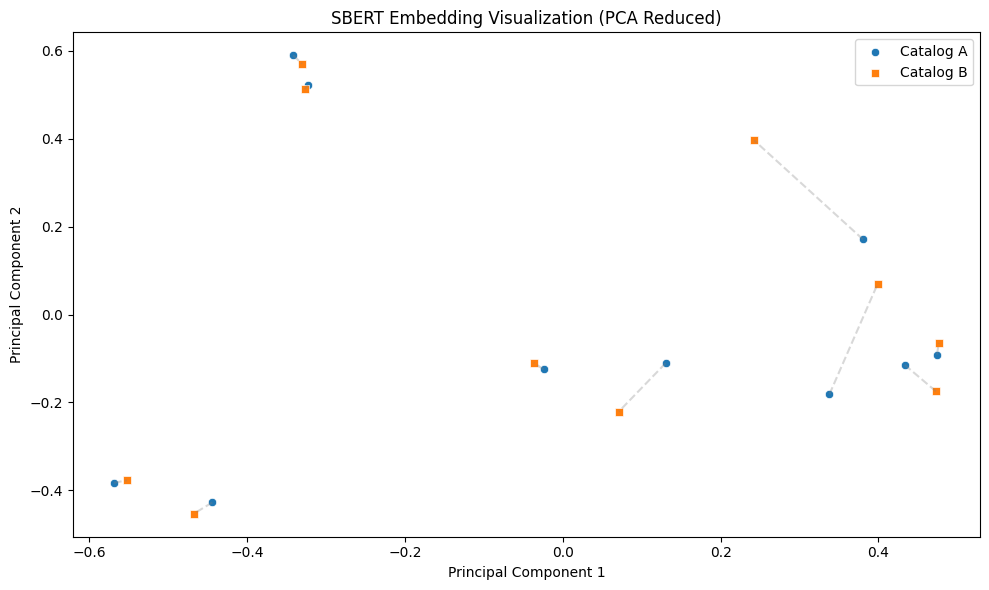

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Convert tensors to numpy
emb_a_np = embeddings_a.cpu().numpy()
emb_b_np = embeddings_b.cpu().numpy()

# Combine both sets of embeddings
all_embeddings = np.vstack((emb_a_np, emb_b_np))

# Reduce to 2D with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Split back into two sets
reduced_a = reduced_embeddings[:len(catalog_a_clean)]
reduced_b = reduced_embeddings[len(catalog_a_clean):]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_a[:, 0], y=reduced_a[:, 1], label="Catalog A", marker='o')
sns.scatterplot(x=reduced_b[:, 0], y=reduced_b[:, 1], label="Catalog B", marker='s')

# Optional: draw lines between closest pairs
for i in range(len(catalog_a_clean)):
    plt.plot([reduced_a[i, 0], reduced_b[i, 0]], 
             [reduced_a[i, 1], reduced_b[i, 1]], 
             color='gray', alpha=0.3, linestyle='--')

plt.title("SBERT Embedding Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


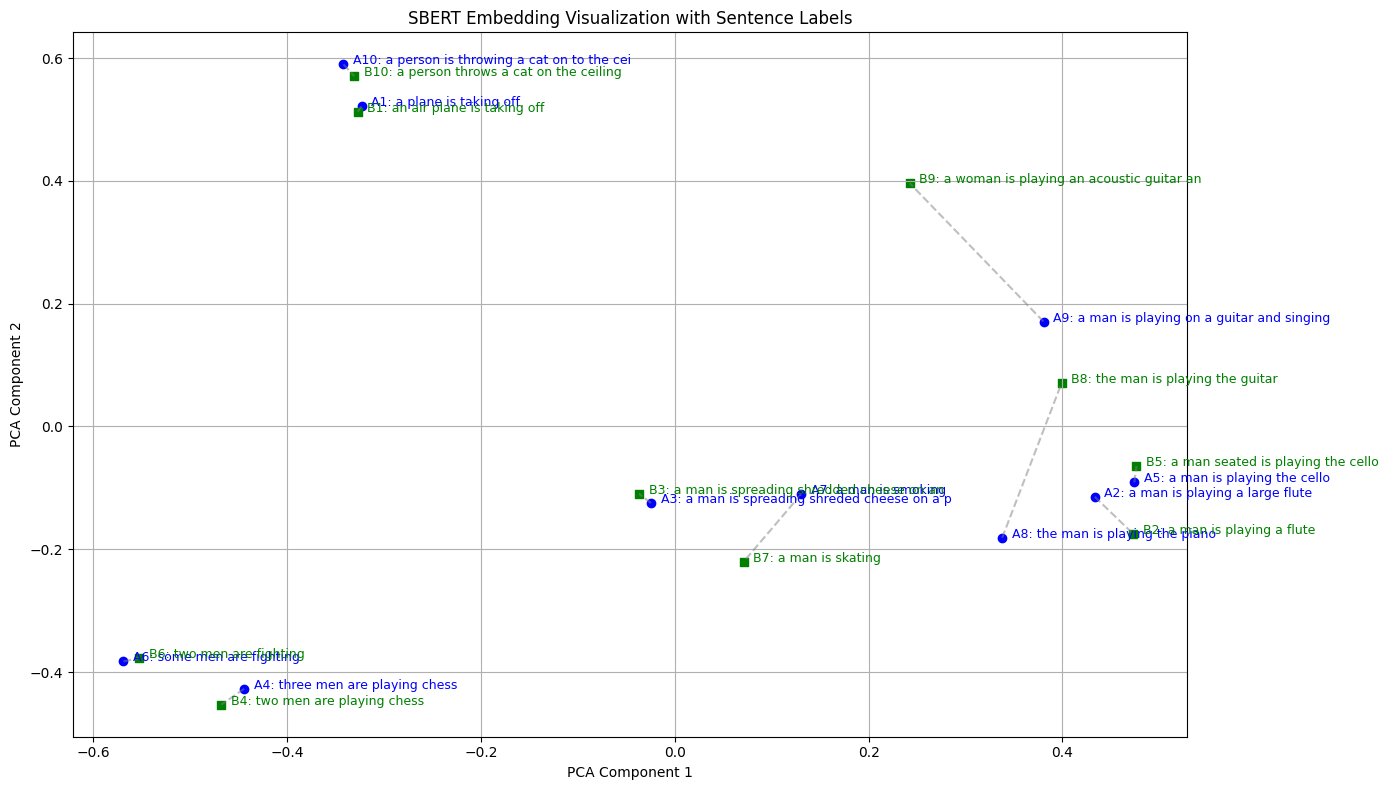

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# Assume you already have these:
# catalog_a_clean and catalog_b_clean (your preprocessed sentence lists)
# embeddings_a and embeddings_b (SBERT output)

# Convert to NumPy
emb_a_np = embeddings_a.cpu().numpy()
emb_b_np = embeddings_b.cpu().numpy()

# Combine for joint PCA
all_embeddings = np.vstack((emb_a_np, emb_b_np))

# Reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings)

# Split back
reduced_a = reduced[:len(catalog_a_clean)]
reduced_b = reduced[len(catalog_a_clean):]

# Plot
plt.figure(figsize=(14, 8))

# Plot Catalog A points
for i, (x, y) in enumerate(reduced_a):
    plt.scatter(x, y, color='blue', marker='o')
    plt.text(x + 0.01, y, f"A{i+1}: {catalog_a_clean[i][:40]}", fontsize=9, color='blue')

# Plot Catalog B points
for i, (x, y) in enumerate(reduced_b):
    plt.scatter(x, y, color='green', marker='s')
    plt.text(x + 0.01, y, f"B{i+1}: {catalog_b_clean[i][:40]}", fontsize=9, color='green')

# Optional: draw dashed lines between A and B (assuming matching index)
for i in range(len(catalog_a_clean)):
    plt.plot(
        [reduced_a[i, 0], reduced_b[i, 0]],
        [reduced_a[i, 1], reduced_b[i, 1]],
        linestyle='--',
        color='gray',
        alpha=0.5
    )

plt.title("SBERT Embedding Visualization with Sentence Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Cosine Similarity (Semantic)


```python
semantic_sim = util.cos_sim(embeddings_a, embeddings_b).cpu().numpy()
````

* **What it does:**
  This line calculates the **cosine similarity** between the sentence embeddings of two catalogs (`catalog_a` and `catalog_b`).

* **Why cosine similarity?**
  Cosine similarity measures the cosine of the angle between two vectors in a high-dimensional space:

  $$
  \text{cosine\_sim}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u} \cdot \mathbf{v}}{\|\mathbf{u}\| \|\mathbf{v}\|}
  $$

  where:

  * $\mathbf{u}$ and $\mathbf{v}$ are embedding vectors for two sentences
  * $\cdot$ denotes the dot product
  * $\|\mathbf{u}\|$ and $\|\mathbf{v}\|$ are vector magnitudes (Euclidean norms)

* **Interpretation:**

  * Values range from -1 (completely opposite) to 1 (identical).
  * Higher scores mean higher semantic similarity, capturing meaning even when wording differs.

* **Details:**

  * `util.cos_sim` computes pairwise cosine similarities between all embeddings in `embeddings_a` and `embeddings_b`.
  * The result is a 2D matrix `semantic_sim` of shape `(len(catalog_a), len(catalog_b))`.
  * `.cpu().numpy()` transfers tensors to CPU and converts them to NumPy arrays for easy manipulation.



In [15]:

# ----------- Cosine Similarity (Semantic) -----------
semantic_sim = util.cos_sim(embeddings_a, embeddings_b).cpu().numpy()


In [16]:
pd.DataFrame(semantic_sim)

,0,1,2,3,4,5,6,7,8,9
0,0.970121,0.064784,0.044300,0.039898,0.047586,0.100853,0.053873,0.099072,0.049572,0.131123
1,0.111262,0.894225,0.081782,0.102157,0.455748,0.051045,0.310353,0.320404,0.069368,0.067096
2,0.033281,0.097392,0.911983,0.128567,0.196698,0.136492,0.245459,0.238686,0.012742,0.117393
3,0.068214,0.071163,0.125768,0.781537,0.086835,0.256762,0.153645,0.048234,-0.141077,0.059067
4,0.043814,0.465426,0.161172,0.096964,0.894459,0.039334,0.206701,0.392317,0.109607,0.077282
5,0.124690,0.067832,0.122904,0.382105,0.012159,0.938277,0.141923,0.072937,-0.063955,0.047857
6,0.111347,0.330201,0.222532,0.088153,0.246346,0.138664,0.343576,0.241926,0.010995,0.035535
7,-0.004850,0.416400,0.232152,0.154822,0.406498,0.001112,0.226499,0.319059,0.022499,0.012123
8,0.081276,0.289402,0.210217,0.011847,0.315176,0.097023,0.179964,0.704682,0.622182,0.057170
9,0.175210,-0.007560,0.093482,0.076894,0.094166,0.055251,0.030202,0.023264,0.064890,0.979712


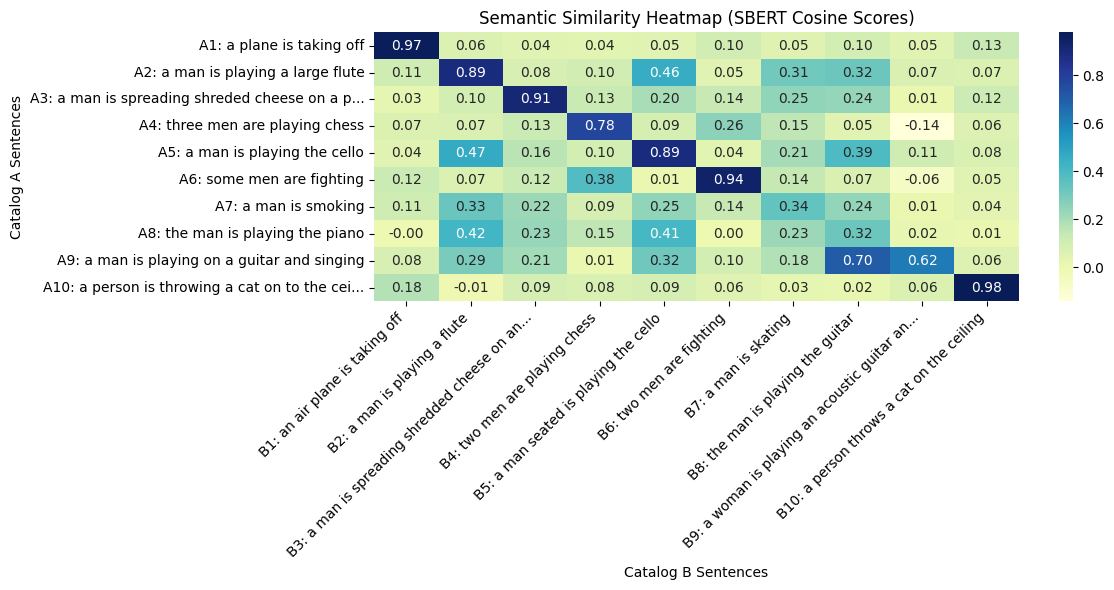

In [17]:
# Optionally truncate long strings for clarity
def truncate(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + '...'

labels_a = [f"A{i+1}: {truncate(s)}" for i, s in enumerate(catalog_a_clean)]
labels_b = [f"B{i+1}: {truncate(s)}" for i, s in enumerate(catalog_b_clean)]

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(semantic_sim, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=labels_b, yticklabels=labels_a)

plt.title("Semantic Similarity Heatmap (SBERT Cosine Scores)")
plt.xlabel("Catalog B Sentences")
plt.ylabel("Catalog A Sentences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


---

## 7. Combining Scores



```python
combined_scores = 0.7 * semantic_sim + 0.3 * jaccard_sim
```

* **What it does:**
  This line combines the semantic and lexical similarity matrices into a single score matrix.

* **Why combine?**

  * **Semantic similarity** captures meaning but may miss exact keyword matches.
  * **Jaccard similarity** captures exact token overlap but not meaning.
  * Combining them leverages the strengths of both methods for better matching accuracy.

* **Weights:**

  * Semantic similarity is weighted **70%** (`0.7`) to prioritize meaning.
  * Jaccard similarity is weighted **30%** (`0.3`) to emphasize lexical overlap.

* **Result:**

  * `combined_scores` is a matrix where each entry represents the combined similarity score between product titles from both catalogs.

---


In [18]:
# ----------- Combine Scores -----------
combined_scores = 0.9 * semantic_sim + 0.1 * jaccard_sim


In [19]:
pd.DataFrame(combined_scores)

,0,1,2,3,4,5,6,7,8,9
0,0.930252,0.083305,0.055255,0.035908,0.062828,0.090768,0.077057,0.100276,0.061282,0.127102
1,0.109227,0.888136,0.096681,0.101941,0.454618,0.045940,0.322175,0.325864,0.087431,0.068720
2,0.037645,0.117653,0.884421,0.115710,0.202028,0.122843,0.254246,0.232999,0.024801,0.121038
3,0.061393,0.075158,0.113191,0.770050,0.087242,0.259657,0.138280,0.054522,-0.119277,0.053160
4,0.048524,0.476026,0.168132,0.097268,0.890728,0.035400,0.228888,0.410228,0.123646,0.087736
5,0.112221,0.061049,0.110614,0.372465,0.010943,0.904449,0.127730,0.065643,-0.057560,0.043071
6,0.111324,0.347181,0.227552,0.079338,0.259211,0.124798,0.369218,0.246304,0.028077,0.041982
7,0.005635,0.417617,0.224322,0.150450,0.415849,0.001001,0.232421,0.353820,0.036915,0.020001
8,0.080840,0.304907,0.217767,0.018995,0.320022,0.087320,0.195301,0.678658,0.614509,0.066838
9,0.164832,0.009863,0.102884,0.069204,0.107826,0.049726,0.045364,0.037604,0.070901,0.941741


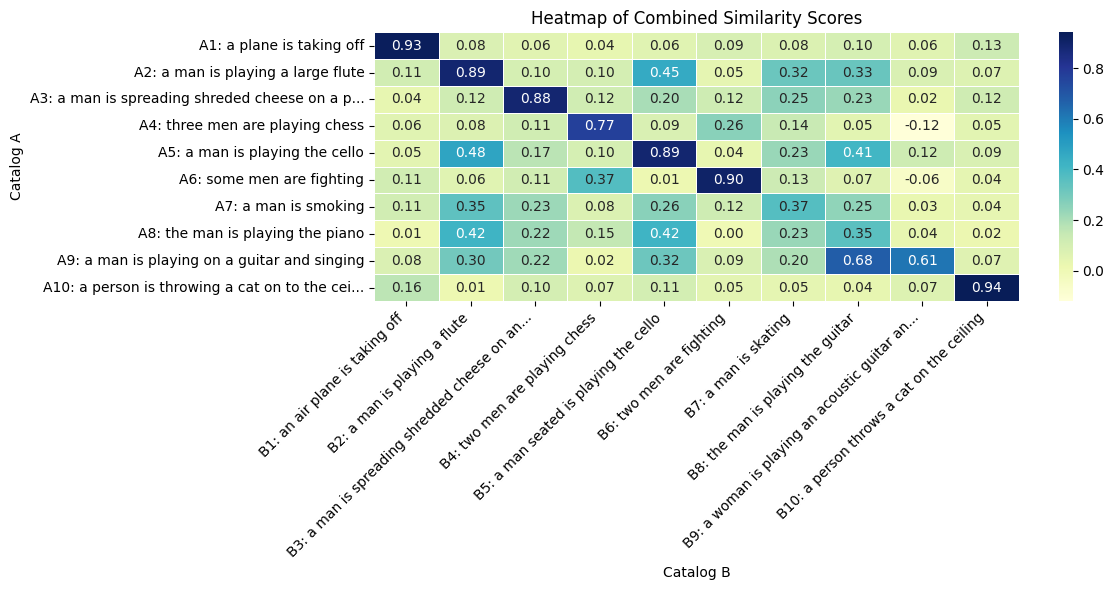

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Optional: truncate long sentences for readability
def truncate(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + "..."

labels_a = [f"A{i+1}: {truncate(s)}" for i, s in enumerate(catalog_a_clean)]
labels_b = [f"B{i+1}: {truncate(s)}" for i, s in enumerate(catalog_b_clean)]

plt.figure(figsize=(12, 6))
sns.heatmap(combined_scores, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=labels_b, yticklabels=labels_a, linewidths=0.5)

plt.title("Heatmap of Combined Similarity Scores")
plt.xlabel("Catalog B")
plt.ylabel("Catalog A")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 8. Product Matching Based on Combined Similarity Scores


### What happens here?

* **Goal:** Identify the best matching products from `catalog_b` for each product in `catalog_a` based on the **combined similarity scores** (semantic + Jaccard).

* **Step-by-step explanation:**

  1. **Initialize parameters:**

     * `top_k = 2`: For each product in catalog A, we consider the top 2 best matches from catalog B.
     * `threshold = 0.5`: A minimum combined similarity score required to consider a match as valid.

  2. **Iterate over products in catalog A:**

     * For each product `i` in `catalog_a`, we print its original title.

  3. **Rank potential matches:**

     * Use `np.argsort(-combined_scores[i])` to sort the similarity scores in descending order (highest similarity first).
     * This gives the indices of catalog B products sorted by similarity to product `i`.

  4. **Select top matches above threshold:**

     * Loop through the top `k` matches.
     * For each match, check if the combined similarity score exceeds the threshold.
     * If yes, print the matched product title from catalog B and the similarity score.
     * Mark `found = True` to indicate at least one strong match was found.

  5. **If no strong match:**

     * If no product meets the threshold, print `"No strong match found."`

  6. **Formatting:**

     * Print a separator line (`"-" * 70`) for clarity between products.

---

### Why this approach?

* **Top-K matches:**
  Helps retrieve multiple possible matches for each product, useful if catalog B has near-duplicate entries.

* **Thresholding:**
  Filters out weak or irrelevant matches, reducing false positives.

* **Combined scores:**
  Using both semantic and lexical similarity makes matching more robust and precise.

---

### Practical considerations

* You can adjust `top_k` depending on how many matches you want to consider.
* The `threshold` can be tuned based on your dataset and the desired precision/recall trade-off.
* This output format is human-readable but can be adapted for automated downstream processing.

---

This matching step is the final and critical stage where similarity calculations translate into actionable product mappings!



In [21]:

# ----------- Match Products -----------
print("Product Matching Results:\n")
top_k = 2
threshold = 0.5

# Store matches for visualization
match_data = []

for i in range(len(catalog_a)):
    print(f"Catalog A: {catalog_a_clean[i]}")
    ranked_indices = np.argsort(-combined_scores[i])
    found = False
    for rank in range(top_k):
        idx = ranked_indices[rank]
        score = combined_scores[i][idx]
        if score >= threshold:
            print(f"  Match {rank+1}: {catalog_b_clean[idx]}")
            print(f"  Combined Score: {score:.4f}")
            print(f"reference score: {ref_score[i]}")
            match_data.append((catalog_a_clean[i], catalog_b[idx], score))
            found = True
    if not found:
        print("  No strong match found.")
    print("-" * 70)


Product Matching Results:

Catalog A: a plane is taking off
  Match 1: an air plane is taking off
  Combined Score: 0.9303
reference score: 1.0
----------------------------------------------------------------------
Catalog A: a man is playing a large flute
  Match 1: a man is playing a flute
  Combined Score: 0.8881
reference score: 0.76
----------------------------------------------------------------------
Catalog A: a man is spreading shreded cheese on a pizza
  Match 1: a man is spreading shredded cheese on an uncooked pizza
  Combined Score: 0.8844
reference score: 0.76
----------------------------------------------------------------------
Catalog A: three men are playing chess
  Match 1: two men are playing chess
  Combined Score: 0.7700
reference score: 0.52
----------------------------------------------------------------------
Catalog A: a man is playing the cello
  Match 1: a man seated is playing the cello
  Combined Score: 0.8907
reference score: 0.85
------------------------

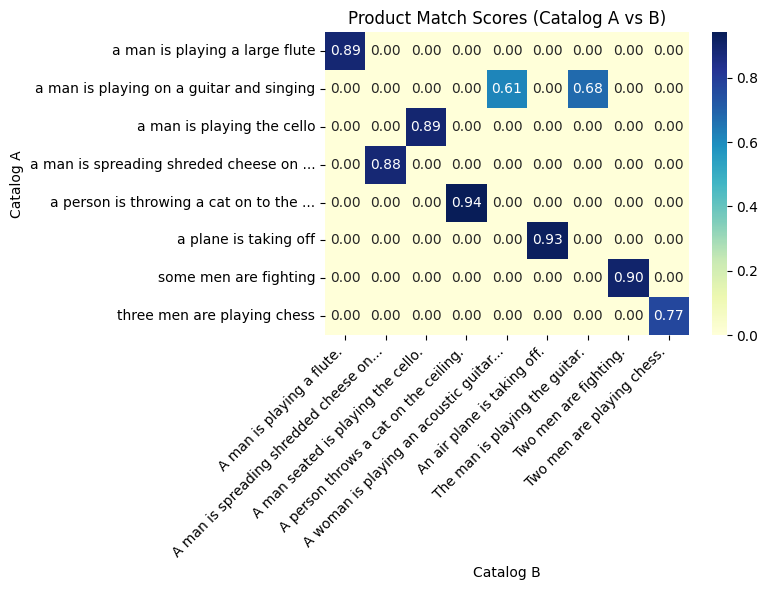

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------- Visualization -----------
if match_data:
    # Truncate helper function
    def truncate(text, max_len=40):
        return text if len(text) <= max_len else text[:max_len - 3] + "..."

    # Convert to heatmap matrix
    labels_a_full = sorted(set(x[0] for x in match_data))
    labels_b_full = sorted(set(x[1] for x in match_data))
    labels_a = [truncate(label) for label in labels_a_full]
    labels_b = [truncate(label) for label in labels_b_full]

    heatmap_matrix = np.zeros((len(labels_a), len(labels_b)))

    for a, b, score in match_data:
        i = labels_a_full.index(a)
        j = labels_b_full.index(b)
        heatmap_matrix[i, j] = score

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=labels_b, yticklabels=labels_a)
    plt.title("Product Match Scores (Catalog A vs B)")
    plt.xlabel("Catalog B")
    plt.ylabel("Catalog A")
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()
else:
    print("No matches found to visualize.")
